In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Create possible haplotypes for RN and associated colour palettes

#4 gene haplotype order and palette
firsta = ['S', 's']
seconda = ['A', 'a']
thirda = ['B', 'b']
fourtha = ['R', 'r']
hap_4gene_poss =[]

for a in firsta:
    for b in seconda:
        for c in thirda:
            for d in fourtha:
                hap_4gene_poss.append(a+b+c+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap_4gene_order = dict(zip(hap_4gene_poss, order))
 
num_cols = len(hap_4gene_poss)
cols = sns.color_palette("husl", num_cols)
col_4gene = dict(zip(hap_4gene_poss, cols))
hap_4_col = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g']

#3 gene haplotype order and palette
firsta = ['S', 's']
seconda = ['A', 'a']
fourtha = ['R', 'r']
hap_3gene_poss =[] 

for a in firsta:
    for b in seconda:
        for d in fourtha:
            hap_3gene_poss.append(a+b+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap_3gene_order = dict(zip(hap_3gene_poss, order))

num_cols = len(hap_3gene_poss)
cols = sns.color_palette("husl", num_cols)
col_3gene = dict(zip(hap_3gene_poss, cols))
hap_3_col = [ 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']

#2 gene haplotype order and palette
firsta = ['C', 'c']
seconda = ['R', 'r']
hap_2gene_poss =[]

for a in firsta:
    for b in seconda:
        hap_2gene_poss.append(a+b)
                
order = [0, 1, 2, 3]
hap_2gene_order = dict(zip(hap_2gene_poss, order))
            
num_cols = len(hap_2gene_poss)
cols = sns.color_palette("husl", num_cols)
col_2gene = dict(zip(hap_2gene_poss, cols))
hap_2_col = ['RN_RUNX1_c', 'RN_RUNX1_g']

In [201]:
#Import the data and flip into a multi index 

def data_retrieval(sourcefile, pt_initials):
    df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
    df = df.stack([0,1,2])
    df = df.reorder_levels([1,0,2,3])
    df = df.to_frame()  #puts everything back in a dataframe
    df.columns = ['Reads']
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Amplicon'] = df.index.get_level_values(2)
    df['Genotype'] = df.index.get_level_values(3)
    df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
    df = df.drop(columns = ['one', 'two'])

    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID') #should this be an input? also in next fucntion
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))

    #Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
    #RN_allele_plate is the key dataset going forward
    pt_allele_plate = df.loc[df['Patient'].isin([pt_initials])] #Make df with just RN data
    pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
    pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
    pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)
    #pt_allele_plate = pt_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    
    return pt_allele_plate

def call_haps (data, haps, reads, cutoff):

#data is the df created by data_retrieval
#haps is the number of haplotypes
#reads is the number of reads per amplicon
#cutoff is the threshold for calling an amplicon as mutant
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Create possible haplotypes for RN and associated colour palettes

    #4 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    thirda = ['B', 'b']
    fourtha = ['R', 'r']
    hap_4gene_poss =[]

    for a in firsta:
        for b in seconda:
            for c in thirda:
                for d in fourtha:
                    hap_4gene_poss.append(a+b+c+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_4gene_order = dict(zip(hap_4gene_poss, order))

    num_cols = len(hap_4gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_4gene = dict(zip(hap_4gene_poss, cols))
    hap_4_col = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g']

    #3 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    fourtha = ['R', 'r']
    hap_3gene_poss =[] 

    for a in firsta:
        for b in seconda:
            for d in fourtha:
                hap_3gene_poss.append(a+b+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_3gene_order = dict(zip(hap_3gene_poss, order))

    num_cols = len(hap_3gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_3gene = dict(zip(hap_3gene_poss, cols))
    hap_3_col = [ 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']

    #2 gene haplotype order and palette
    firsta = ['C', 'c']
    seconda = ['R', 'r']
    hap_2gene_poss =[]

    for a in firsta:
        for b in seconda:
            hap_2gene_poss.append(a+b)

    order = [0, 1, 2, 3]
    hap_2gene_order = dict(zip(hap_2gene_poss, order))

    num_cols = len(hap_2gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_2gene = dict(zip(hap_2gene_poss, cols))
    hap_2_col = ['RN_RUNX1_c', 'RN_RUNX1_g']
    
    if haps == 4:
        cols = hap_4_col
    
    elif haps == 2:
        cols = hap_2_col
        
    elif haps == 3:
        cols = hap_3_col
        
    else:
        print('Enter 2, 3, or 4 haplotypes')
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = ['RN_RUNX1_c','RN_RUNX1_g','RN_SRSF2','RN_TET2a','RN_TET2b_c','RN_TET2b_g']
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads for {haps} genes = ', len(wells))
    
    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']

    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])

    conditions = [(df2['Mut_freq'] <= cutoff), (df2['Mut_freq']) > cutoff ]
    values = ['w', 'm']
    df2['Genotype'] = np.select(conditions, values)
    df2 = df2.drop(columns = ['Mut_freq']).unstack(2)
    df2.columns = cols
    
    if 'RN_RUNX1_g' in df2.columns:
        df2.loc[:,'RN_RUNX1_g'].replace({'w':'R','m':'r' }, inplace = True)
        
    if 'RN_SRSF2' in df2.columns:  
        df2.loc[:,'RN_SRSF2'].replace({'w':'S','m':'s' }, inplace = True)
        
    if 'RN_TET2a' in df2.columns:     
        df2.loc[:,'RN_TET2a'].replace({'w':'A','m':'a' }, inplace = True)
        
    if 'RN_TET2b_g' in df2.columns:
        df2.loc[:,'RN_TET2b_g'].replace({'w':'B','m':'b' }, inplace = True)
        
    if 'RN_RUNX1_c' in df2.columns:   
        df2.loc[:,'RN_RUNX1_c'].replace({'w':'C','m':'c' }, inplace = True)
        
    df2['Haplotype'] = 'x'

    for idx, row in df2.iterrows():
        
        if haps == 3:
            a = row['RN_SRSF2'] + row['RN_TET2a'] + row['RN_RUNX1_g']
        elif haps == 4:
            a = row['RN_SRSF2'] + row['RN_TET2a'] + row['RN_TET2b_g'] + row['RN_RUNX1_g']
        elif haps ==2:
            a = row['RN_RUNX1_c'] + row['RN_RUNX1_g']
        
        row['Haplotype'] = row['Haplotype'].replace('x', a)   
    
    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = cols)
    df2 = df2.drop(columns = ['Plate', 'Well'])

    return df2

def plot_hap_dist_sort_type(data):
    
    #4 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    thirda = ['B', 'b']
    fourtha = ['R', 'r']
    hap_4gene_poss =[]

    for a in firsta:
        for b in seconda:
            for c in thirda:
                for d in fourtha:
                    hap_4gene_poss.append(a+b+c+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_4gene_order = dict(zip(hap_4gene_poss, order))

    num_cols = len(hap_4gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_4gene = dict(zip(hap_4gene_poss, cols))
    hap_4_col = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g']

    #3 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    fourtha = ['R', 'r']
    hap_3gene_poss =[] 

    for a in firsta:
        for b in seconda:
            for d in fourtha:
                hap_3gene_poss.append(a+b+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_3gene_order = dict(zip(hap_3gene_poss, order))

    num_cols = len(hap_3gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_3gene = dict(zip(hap_3gene_poss, cols))
    hap_3_col = [ 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']

    #2 gene haplotype order and palette
    firsta = ['C', 'c']
    seconda = ['R', 'r']
    hap_2gene_poss =[]

    for a in firsta:
        for b in seconda:
            hap_2gene_poss.append(a+b)

    order = [0, 1, 2, 3]
    hap_2gene_order = dict(zip(hap_2gene_poss, order))

    num_cols = len(hap_2gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_2gene = dict(zip(hap_2gene_poss, cols))
    hap_2_col = ['RN_RUNX1_c', 'RN_RUNX1_g']
    
    #rename the input data and work out how many haplotypes it has
    df3 = data.copy()
    haps = len(df3.iloc[0,0])
    sortcells = [ 'nBCs', 'CD34', 'CD34+/38-', 'NEs', 'Monocytes']
    cellnumb = len(sortcells)
    indexcells = df3['celltype'].drop_duplicates().to_list() #don't really need this line, but might use later
    
    #Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
    fig, axes = plt.subplots(3,2, figsize = (16,8))
    fig.subplots_adjust(hspace = 0.8, wspace=.3)
    ax = axes.ravel()
    count = 0

    c = df3['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

    #set up correct variables for the number of input haplotypes
    
    if haps == 2:
        hap_poss = hap_2gene_poss
        hap_order = hap_2gene_order
        color = col_2gene
        
    if haps == 3:
        hap_poss = hap_3gene_poss
        hap_order = hap_3gene_order
        color = col_3gene
        
    if haps == 4:
        hap_poss = hap_4gene_poss
        hap_order = hap_4gene_order
        color = col_4gene
        
    #if any haplotype is not present, add it into the frame with freq 0 

    for h in hap_poss:
        if h not in str(c['hap']):  #for some reason this needs to be called as a string, wasn't needed outside function
            dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
            c = c.append(dfh)

    c['order'] = c['hap']
    c = c.replace({'order': hap_3gene_order})
    c = c.sort_values(by=['order'])
    d = c['counts'].sum()
    c['proportion'] = c['counts']/d

    ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = color, ax = ax[count], ci = None) #fro scatter add  hue = 'hap'
    ax[0].set_title('All cells') 
    ax[0].set_ylabel('Number of cells', fontsize = 14)
    ax[0].set_xlabel('Haplotype', fontsize = 14)
    ax[0].tick_params(axis='x', labelrotation = 90)
    #ax[0].set_ylim(0.001,0.999)
    #ax[count].set_yscale('logit') #use this only with scatterplot
    
    
    for cell in sortcells:
        count += 1
    
        if df3.loc[df3['Sort_cell_type'].isin([cell])].empty == False:

            a = df3.loc[df3['Sort_cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

            #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
            for h in hap_poss:
                if h not in str(a['hap']):  #for some reason this needs to be called as a string, wasn't needed outside function
                    dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                    a = a.append(dfh)    

            a['order'] = a['hap']
            a = a.replace({'order': hap_order})
            a = a.sort_values(by=['order'])
            b = a['counts'].sum()
            a['proportion'] = a['counts']/b

            ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = color,  ax = ax[count], ci = None) #for scatter add  hue = 'hap'
            ax[count].set_title(str(cell)) 
            ax[count].set_ylabel('Number of cells', fontsize = 14)
            ax[count].set_xlabel('Haplotype', fontsize = 14)
            ax[count].tick_params(axis='x', labelrotation = 90)
            #ax[count].set_ylim(0.001,0.999)
            #ax[count].set_yscale('logit') #use this only with scatterplot

        else:
            continue
            
#Now plot the heatmaps

def plot_index_heatmap(data, title):
    df = data.copy()
    a = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    a = a * 100 /a.sum(axis = 0)
    #How to control order if a different set of cell types are represented?   
    alltypes = ['CMP', 'GMP2', 'GMP', 'MEP', 'MPP', 'unassigned', 'HSC', 'MDS_SC', 'NE', 'CD14pos_mono', 'CD14neg_mono', 'nBC']
    order = [3, 6, 5, 4, 1, 12, 0, 2, 7, 8, 9, 10]
    col_order = dict(zip(alltypes, order))
    
    a = a.T
    a['ct'] = a.index.get_level_values(0)
    a = a.replace({'ct': col_order})
    a = a.sort_values(by=['ct'])
    a = a.drop(columns = ['ct'])
    a = a.T

    fig, ax = plt.subplots(figsize = (16, 6))
    ax = sns.heatmap(data = a, ax = ax, robust = True)
    ax.tick_params(axis='y', labelrotation = 0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)  
    
    x = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    x = x.sum(axis = 0)
    x = x.to_frame()
    x['order'] = x.index.get_level_values(0)
    x = x.replace({'order': col_order})
    x = x.sort_values(by=['order'])
    x = x.drop(columns = ['order'])
    x['ct'] = x.index.get_level_values(0)
    x.columns = ['number', 'ct']
#    x = x.T
#    x['ct'] = x.index.get_level_values(0)
#    x.loc[0, 'ct'] = 'cell'
#    x = x.set_index('ct')
#    x.index.name = None
    
    fig2, ax2 = plt.subplots(figsize = (12.8, 1))
    ax2 = sns.scatterplot(x = 'ct', y = 'number', data = x, ax = ax2, s = 100, color = 'green')
#    ax2 = sns.heatmap(data = x, ax = ax2)
    ax2.tick_params(axis='x', labelrotation = 90)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.axhline(10, ls = '--', c = 'gray')
    ax2.axhline(100, ls = '--', c = 'gray')
    ax2.set_ylim(1,1000)
    ax2.set_yscale('log') #use this only with scatterplot
    ax2.set_title('Total number of cells for each type')  

In [114]:
#QC just checking the output is the same.
#The columns (L-R) are; [('Reads', 'RN_RUNX1_c'), ('Reads', 'RN_RUNX1_g'), ('Reads', 'RN_SRSF2'), ('Reads', 'RN_TET2a'), ('Reads', 'RN_TET2b_c'), ('Reads', 'RN_TET2b_g')]
#Cells with 100 reads for 3 genes (plate1) =  794
#Cells with 15 reads for 4 genes (plate2) =  162
#Cells with 50 reads for RUNX1 cDNA and gDNA (plate3) =  1645
#Cells with 10 reads for 4 genes (plate4) =  253
#Cells with 50 reads for 3 genes (plate5) =  1234

Cells with 50 reads for 3 genes =  1234


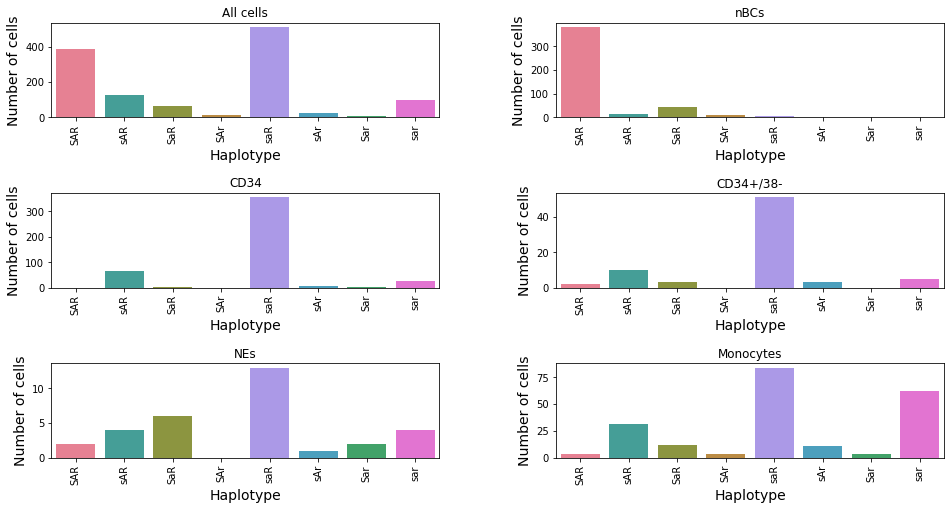

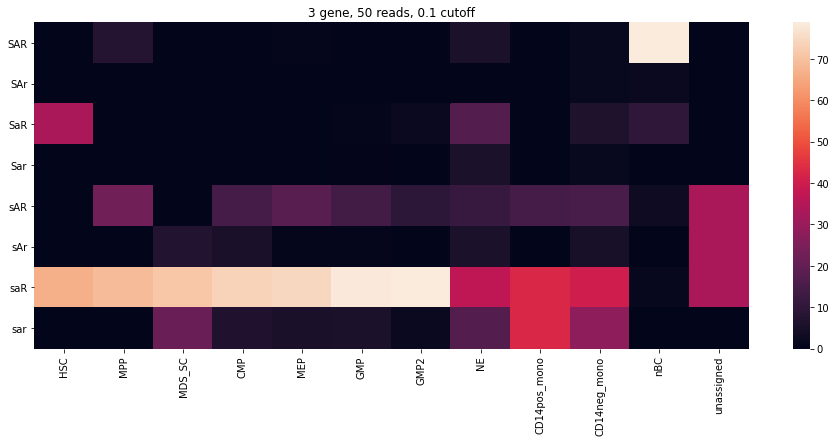

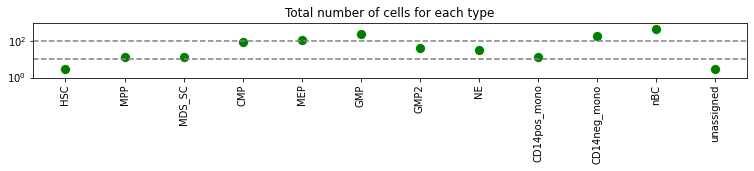

In [203]:
datafile = '../Data/Amp_data/allele_counts.tsv'
index_data = pd.read_csv('../Data/Amp_data/RN_comp_celltype_assignment.tsv', index_col = 0, sep = '\t')
RN_plate = data_retrieval(datafile, 'RN')  
RN_haps = call_haps(RN_plate, 3, 50, 0.1) #hap number, read cut, proprtion mutated
RN_haps_indexed = pd.merge(RN_haps, index_data, on = 'Plate_Well')
plot_hap_dist_sort_type(RN_haps_indexed)
plot_index_heatmap(RN_haps_indexed, '3 gene, 50 reads, 0.1 cutoff')

In [6]:
#what about the hypercube plots?


def count_muts(x):
    return (np.array(['S', 'A', 'B', 'R']) != list(x)).sum()

def hap_cube_graph(data):
    #Four haplotype graph
    haplo_freqs = pd.DataFrame.from_dict(counts2, orient='index', columns = ['freq'])  #put the desired freq list here
    cut = cutoff2 #put cutoff variable for data here



    haplo_freqs['n_muts'] = [count_muts(x) for x in haplo_freqs['freq'].index] #Count of how many genes are mutated in that haplotype

    hmax = haplo_freqs['freq'].max()
    fig, ax = plt.subplots(figsize = (16,8))
    for nmut in range(5):
        hap = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut]
        nh = len(hap)
        ys = np.arange(nh) - 0.5 * (nh - 1)
        xs = [nmut] * len(ys)

        # Sizes
        #s = 2 + 150 * np.sqrt(hap['freq'].values / hmax)
        s = 2 + 300 * (hap['freq'].values / hmax)

        # Color
        c = ['green' if x in trajectory4 else 'k' for x in hap.index]

        ax.scatter(xs, ys, s=s, c=c)

        for hname, y in zip(hap.index, ys):
            if (y >= 0) & (nmut < 1.5):
                ax.text(nmut - 0.05, y + 0.05, hname, ha='right',
    va='bottom')
            elif y >= 0:
                ax.text(nmut + 0.05, y + 0.05, hname, ha='left',
    va='bottom')
            elif nmut < 1.5:
                ax.text(nmut - 0.05, y - 0.08, hname, ha='right', va='top')
            else:
                ax.text(nmut + 0.05, y - 0.08, hname, ha='left', va='top')

        if nmut != 4:
            hap2 = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut + 1]
            nh2 = len(hap2)
            ys2 = np.arange(nh2) - 0.5 * (nh2 - 1)
            for hname, y in zip(hap.index, ys):
                for hname2, y2 in zip(hap2.index, ys2):
                    skip = False
                    for i in range(len(hname)):
                        if (hname[i] == hname[i].lower()) and (hname2[i] == hname2[i].upper()):
                            skip = True
                            break               

                    if skip:
                        continue



                    if (trajectory4[nmut] == hname) and (trajectory4[nmut 
    + 1] == hname2):
                        lw = 3
                        color = 'green'
                    else:
                        lw = 0.5
                        color = 'grey'
                    ax.plot([nmut, nmut+1], [y, y2], color=color, lw=lw, zorder=0)

    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(np.arange(5))
    ax.set_xlabel('N mutations')
    ax.set_ylim(-3, 3)
    ax.set_yticks([])
    #fig.tight_layout()

    fig.suptitle('4 gene, 15 read per amplicon binary haplotype frequency, all cells, genotype cutoff is ' + str(cutoff2), fontsize=16)
    fig.savefig('../Results/Haplotypes/Haplotype_4gen_15amp_cutoff_trajectory'+str(cutoff2)+ '.png',dpi=300)

    plt.ion(); plt.show()